In [1]:
import pyspark

In [2]:
pyspark.__version__

'3.4.1'

In [3]:
pyspark.__file__

'/home/liltimz/spark/spark-3.4.1-bin-hadoop3-scala2.13/python/pyspark/__init__.py'

In [4]:
import matplotlib.pyplot as plt

In [5]:
pip install pandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd

In [7]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, SQLContext

In [8]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName('SparkLM') \
    .getOrCreate()

23/07/17 10:01:29 WARN Utils: Your hostname, DESKTOP-L19S3UO resolves to a loopback address: 127.0.1.1; using 172.23.77.168 instead (on interface eth0)
23/07/17 10:01:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/17 10:01:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [9]:
spark

In [10]:
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.regression import LinearRegression

In [11]:
df = spark.read \
    .option("header", "true") \
    .csv('cars.csv')

In [12]:
df.show()

+----+---------+------------+----------+------+------------+----------+------+--------------------+
| mpg|cylinders|displacement|horsepower|weight|acceleration|model_year|origin|                name|
+----+---------+------------+----------+------+------------+----------+------+--------------------+
|18.0|        8|       307.0|     130.0|  3504|        12.0|        70|   usa|chevrolet chevell...|
|15.0|        8|       350.0|     165.0|  3693|        11.5|        70|   usa|   buick skylark 320|
|18.0|        8|       318.0|     150.0|  3436|        11.0|        70|   usa|  plymouth satellite|
|16.0|        8|       304.0|     150.0|  3433|        12.0|        70|   usa|       amc rebel sst|
|17.0|        8|       302.0|     140.0|  3449|        10.5|        70|   usa|         ford torino|
|15.0|        8|       429.0|     198.0|  4341|        10.0|        70|   usa|    ford galaxie 500|
|14.0|        8|       454.0|     220.0|  4354|         9.0|        70|   usa|    chevrolet impala|


In [14]:
df = df.select("mpg", "weight", "horsepower")
df.show()


+----+------+----------+
| mpg|weight|horsepower|
+----+------+----------+
|18.0|  3504|     130.0|
|15.0|  3693|     165.0|
|18.0|  3436|     150.0|
|16.0|  3433|     150.0|
|17.0|  3449|     140.0|
|15.0|  4341|     198.0|
|14.0|  4354|     220.0|
|14.0|  4312|     215.0|
|14.0|  4425|     225.0|
|15.0|  3850|     190.0|
|15.0|  3563|     170.0|
|14.0|  3609|     160.0|
|15.0|  3761|     150.0|
|14.0|  3086|     225.0|
|24.0|  2372|      95.0|
|22.0|  2833|      95.0|
|18.0|  2774|      97.0|
|21.0|  2587|      85.0|
|27.0|  2130|      88.0|
|26.0|  1835|      46.0|
+----+------+----------+
only showing top 20 rows



In [15]:
df.head()

Row(mpg='18.0', weight='3504', horsepower='130.0')

In [16]:
df.toPandas()

,mpg,weight,horsepower
0,18.0,3504,130.0
1,15.0,3693,165.0
2,18.0,3436,150.0
3,16.0,3433,150.0
4,17.0,3449,140.0
...,...,...,...
393,27.0,2790,86.0
394,44.0,2130,52.0
395,32.0,2295,84.0
396,28.0,2625,79.0


In [29]:
from pyspark.sql.functions import col




In [32]:
df = df.withColumn("mpg", col("mpg").cast("double"))
df = df.withColumn("weight", col("weight").cast("double"))
df = df.withColumn("horsepower", col("horsepower").cast("double"))

In [33]:
df.printSchema()

root
 |-- mpg: double (nullable = true)
 |-- weight: double (nullable = true)
 |-- horsepower: double (nullable = true)



In [40]:
df.show(10)

+----+------+----------+
| mpg|weight|horsepower|
+----+------+----------+
|18.0|3504.0|     130.0|
|15.0|3693.0|     165.0|
|18.0|3436.0|     150.0|
|16.0|3433.0|     150.0|
|17.0|3449.0|     140.0|
|15.0|4341.0|     198.0|
|14.0|4354.0|     220.0|
|14.0|4312.0|     215.0|
|14.0|4425.0|     225.0|
|15.0|3850.0|     190.0|
+----+------+----------+
only showing top 10 rows



In [44]:
df = df.dropna()


In [68]:
#VectorAssembler() function to convert the dataframe columns into feature vectors
assembler = VectorAssembler(
    inputCols=["horsepower", "weight"],
    outputCol="features")

output = assembler.transform(df).select('features','mpg')

In [69]:
#create a test-train split of 75%-25%
train, test = output.randomSplit([0.75, 0.25])

In [70]:
#Correlation function is a part of the Stat library. correlation function is used to determine the different types of correlation between the 2 features - "horsepower" and "weight".
r1 = Correlation.corr(train, "features").head()
print("Pearson correlation matrix:\n" + str(r1[0]))

Pearson correlation matrix:
DenseMatrix([[1.        , 0.86204282],
             [0.86204282, 1.        ]])


In [73]:
r2 = Correlation.corr(train, "features", "spearman").head()
print("Spearman correlation matrix:\n" + str(r2[0]))

Spearman correlation matrix:
DenseMatrix([[1.        , 0.87818604],
             [0.87818604, 1.        ]])


In [74]:
#correlation matrix for the test dataset split created above
r1 = Correlation.corr(test, "features").head()
print("Pearson correlation matrix:\n" + str(r1[0]))

Pearson correlation matrix:
DenseMatrix([[1.        , 0.87237486],
             [0.87237486, 1.        ]])


There is a 0.86 (or 86%) correlation between the features. That is logical as a car with higher horsepower likely has a bigger engine and thus weighs more. We can also visualize the feature vectors to see that they are indeed correlated.

In [78]:
#Normalizing the training features by using the L2 norm of the feature vector
normalizer_l2 = Normalizer(inputCol="features", outputCol="features_normalized", p=2.0)
train_norm_l2 = normalizer_l2.transform(train)

print("Normalized using L^2 norm:")
train_norm_l2.show(5, truncate=False)

Normalized using L^2 norm:
+-------------+------------------+-----------------------------------------+
|features     |mpg               |features_normalized                      |
+-------------+------------------+-----------------------------------------+
|[46.0,1835.0]|26.0              |[0.025060247064771873,0.9996859426925301]|
|[48.0,1985.0]|43.099998474121094|[0.024174293418232337,0.999707759066483] |
|[48.0,2335.0]|43.400001525878906|[0.0205524031257623,0.9997887770553118]  |
|[52.0,1649.0]|31.0              |[0.03151859588417022,0.9995031656345518] |
|[52.0,1985.0]|32.79999923706055 |[0.026187489441971207,0.9996570488906317]|
+-------------+------------------+-----------------------------------------+
only showing top 5 rows



In [80]:
import sys
sys.setrecursionlimit(100)


RecursionError: maximum recursion depth exceeded in comparison

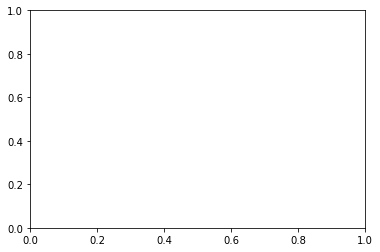

In [82]:
plt.figure()
plt.scatter(df["horsepower"], df["weight"])
plt.xlabel("horsepower")
plt.ylabel("weight")
plt.title("Correlation between Horsepower and Weight")
plt.show()

# Normalization

In [54]:
#normalize feature vectors for better model training and convergence.
normalizer = Normalizer(inputCol="features", outputCol="features_normalized", p=1.0)
train_norm = normalizer.transform(train)
print("Normalized using L^1 norm")
train_norm.show(5, truncate=False)

Normalized using L^1 norm
+-------------+------------------+-----------------------------------------+
|features     |mpg               |features_normalized                      |
+-------------+------------------+-----------------------------------------+
|[46.0,1835.0]|26.0              |[0.024455077086656035,0.9755449229133439]|
|[46.0,1950.0]|26.0              |[0.023046092184368736,0.9769539078156313]|
|[48.0,1985.0]|43.099998474121094|[0.023610427939006393,0.9763895720609936]|
|[48.0,2085.0]|44.29999923706055 |[0.02250351617440225,0.9774964838255977] |
|[48.0,2335.0]|43.400001525878906|[0.020142677297524128,0.9798573227024758]|
+-------------+------------------+-----------------------------------------+
only showing top 5 rows



In [55]:
#scale the features such that all columns in the features have zero mean and unit variance
standard_scaler = StandardScaler(inputCol="features", outputCol="features_scaled")
train_model = standard_scaler.fit(train)
train_scaled = train_model.transform(train)
train_scaled.show(5, truncate=False)

+-------------+------------------+---------------------------------------+
|features     |mpg               |features_scaled                        |
+-------------+------------------+---------------------------------------+
|[46.0,1835.0]|26.0              |[1.1779918595350867,2.130197121253838] |
|[46.0,1950.0]|26.0              |[1.1779918595350867,2.263697213321517] |
|[48.0,1985.0]|43.099998474121094|[1.2292088969061772,2.304327676124724] |
|[48.0,2085.0]|44.29999923706055 |[1.2292088969061772,2.4204147127053144]|
|[48.0,2335.0]|43.400001525878906|[1.2292088969061772,2.7106323041567912]|
+-------------+------------------+---------------------------------------+
only showing top 5 rows



In [56]:
test_scaled = train_model.transform(test)
test_scaled.show(5, truncate=False)

+-------------+----+---------------------------------------+
|features     |mpg |features_scaled                        |
+-------------+----+---------------------------------------+
|[52.0,2035.0]|29.0|[1.3316429716483587,2.362371194415019] |
|[52.0,2130.0]|44.0|[1.3316429716483587,2.47265387916658]  |
|[60.0,2164.0]|24.5|[1.5365111211327216,2.512123471603981] |
|[63.0,2051.0]|30.5|[1.6133366771893578,2.3809451202679135]|
|[65.0,1773.0]|31.0|[1.6645537145604483,2.0582231585738717]|
+-------------+----+---------------------------------------+
only showing top 5 rows



# Building and Training a Linear Regression Model

Training a Linear Regression model lrModel on the training dataset. Train the model on the standard scaled version of features and also print the final RMSE and R-Squared metrics.



1. I createed the model using the LinearRegression() class and train using the fit() function

In [57]:
# Create a LR model
lr = LinearRegression(featuresCol='features_scaled', labelCol='mpg', maxIter=100)

# Fit the model
lrModel = lr.fit(train_scaled)

# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
#trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("R-squared: %f" % trainingSummary.r2)

23/07/17 11:31:41 WARN Instrumentation: [200cb403] regParam is zero, which might cause numerical instability and overfitting.


Coefficients: [-1.8726616024653224,-4.985134913295616]
Intercept: 45.706482099040805
RMSE: 4.154833
R-squared: 0.719697


RMSE (Root mean squared error) of 4.26. This means that our model predicts the mpg with an average error of 4.2 units

2. Predict on new data

Once a model is trained, it can transform() new unseen data (for eg. the test data) to generate predictions. In the below cell, notice the "prediction" column that contains the predicted "mpg".

In [66]:
lrModel.transform(test_scaled).show(5)

+-------------+----+--------------------+------------------+
|     features| mpg|     features_scaled|        prediction|
+-------------+----+--------------------+------------------+
|[52.0,2035.0]|29.0|[1.33164297164835...|31.436026318399925|
|[52.0,2130.0]|44.0|[1.33164297164835...|30.886252256312947|
|[60.0,2164.0]|24.5|[1.53651112113272...| 30.30584229593222|
|[63.0,2051.0]|30.5|[1.61333667718935...|30.815915806130896|
|[65.0,1773.0]|31.0|[1.66455371456044...| 32.32881614538224|
+-------------+----+--------------------+------------------+
only showing top 5 rows



In [84]:
#training model showing for another 100 iterations and the coefficients.

# Create a Linear Regression model
lr = LinearRegression(featuresCol='features_scaled', labelCol='mpg', maxIter=200)  # Update maxIter to 200

# Fit the model on the training data
lrModel = lr.fit(train_scaled)

# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))


23/07/17 12:52:38 WARN Instrumentation: [61cd774e] regParam is zero, which might cause numerical instability and overfitting.


Coefficients: [-1.8726616024653224,-4.985134913295616]
Intercept: 45.706482099040805
